##이미지 전처리 및 기본 모델링

In [ ]:
#TPU 설정
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
# 필요한 라이브러리 다운로드 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.cm as cm
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

###Resize = 299 for InceptionResNetV2,  InceptionV3

In [ ]:
folder_path = '/content/drive/MyDrive/final'
label_names = os.listdir(folder_path)  # 해당경로의 하위목록의 폴더이름을 리스트로 뽑아냄 
label_names

['welshcorgi_fat',
 'goldenretriever_no',
 'shiba_no',
 'shiba_fat',
 'pug_fat',
 'dachshund_fat',
 'pug_no',
 'goldenretriever_fat',
 'welshcorgi_no',
 'dachshund_no',
 'chihuahua_no',
 'bulldog_fat',
 'chihuahua_fat',
 'bulldog_no']

In [ ]:
dataset = {}

# 이미지와 라벨 리스트에 담기  # label names가 돌면서
for label in os.listdir(folder_path):    
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []   # dataset에 label 선언
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

dataset

{'welshcorgi_fat': ['/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_047.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_038.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_044.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_041.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_048.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_051.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_050.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_052.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_049.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_053.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_045.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_025.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_084.jpg',
  '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_031.jpg',
  '/content/drive/MyDrive/final/welshcorgi_f

In [ ]:
!mkdir resized  

In [ ]:
!mkdir resized/bulldog_fat
!mkdir resized/bulldog_no
!mkdir resized/chihuahua_fat
!mkdir resized/chihuahua_no
!mkdir resized/dachshund_fat
!mkdir resized/dachshund_no
!mkdir resized/goldenretriever_fat
!mkdir resized/goldenretriever_no
!mkdir resized/pug_fat
!mkdir resized/pug_no
!mkdir resized/shiba_fat
!mkdir resized/shiba_no
!mkdir resized/welshcorgi_fat
!mkdir resized/welshcorgi_no

In [ ]:
dataset.items()

dict_items([('welshcorgi_fat', ['/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_047.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_038.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_044.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_041.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_048.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_051.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_050.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_052.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_049.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_053.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_045.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_025.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_084.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_031.jpg', '/content/drive/MyDrive/final/welshcorgi_fat/welsh_fat_039

In [ ]:
for label, filenames in tqdm(dataset.items()):
    for filename in filenames:
        img = cv2.imread(filename)  # 해당이미지를 읽어들여서 저장하겠다. 

# 직사각형의 이미지를 읽어 들여서 가로와 세로 길이를 확인, 짧은 쪽을 긴 쪽에 맞춤 -> 정사각형으로 맞춤 -> 검정 패딩을 씌움
        # 이미지의 x, y가 224이 넘을 경우 작게해주기
        percent = 1
        if(img.shape[1] > img.shape[0]) :       # 이미지의 가로가 세보다 크면 가로를 640으로 맞추고 세로를 비율에 맞춰서
            percent = 299/img.shape[1]          # 열이 큰지 행이 큰지 비교 -> 큰쪽 사이즈에 맞춤 
        else :
            percent = 299/img.shape[0]

        img = cv2.resize(img, dsize=(0, 0), fx=percent, fy=percent, interpolation=cv2.INTER_LINEAR)   # fx와 fy의 비율은 동일하게. 
                # 이미지 범위 지정
        y,x,h,w = (0,0,img.shape[0], img.shape[1])   # height 세로, width 가로

        # 그림 주변에 검은색으로 칠하기
        w_x = (299-(w-x))/2  # w_x = (224 - 그림)을 뺀 나머지 영역 크기 [ 그림나머지/2 [그림] 그림나머지/2 ]    x=0, y=0
        h_y = (299-(h-y))/2

        if(w_x < 0):         # 크기가 -면 0으로 지정.
            w_x = 0
        elif(h_y < 0):
            h_y = 0

        M = np.float32([[1,0,w_x], [0,1,h_y]])  #(2*3 이차원 행렬)
        img_re = cv2.warpAffine(img, M, (299, 299)) #이동변환  
       
        # cv2.imwrite('{0}.jpg',image .format(file)) #파일저장
        cv2.imwrite('/content/resized/{0}/{1}'.format(label, filename.split("/")[-1]) , img_re)

  0%|          | 0/14 [00:00<?, ?it/s]

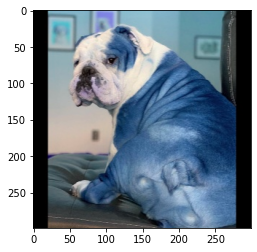

In [ ]:
plt.imshow(cv2.imread('/content/resized/bulldog_fat/bull_fat_001.jpg'))

In [ ]:
# splitfolders.ratio('resized', output='dataset', seed=77, ratio=(0.6, 0.2, 0.2))   # 폴더 안에 데이터가 있는 경우 -> 6:2:2로 트레인 벨리데이션 테스트로 나눔
#                                                                                   # validation 검증용

In [ ]:
splitfolders.ratio('resized', output='dataset', seed=77, ratio=(.6,.4))   # 폴더 안에 데이터가 있는 경우 -> 6:2:2로 트레인 벨리데이션 테스트로 나눔
                                                                                  # validation 검증용

Copying files: 2001 files [00:00, 6945.53 files/s]


In [ ]:
folder_path = '/content/dataset/train'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

dataset

{'dachshund_fat': ['/content/dataset/train/dachshund_fat/dachs_fat_017.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_039.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_068.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_060.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_076.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_070.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_059.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_037.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_040.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_098.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_063.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_080.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_119.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_129.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_088.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_007.jpg',
  '/content/dataset/tra

In [ ]:
label2index = {'bulldog_fat' : 0, 'bulldog_no' : 1 , 'chihuahua_fat' : 2 , 'chihuahua_no' : 3,
               'dachshund_fat' : 4, 'dachshund_no' : 5, 'goldenretriever_fat': 6, 'goldenretriever_no' : 7, 
               'pug_fat' : 8, 'pug_no' : 9, 'shiba_fat' : 10, 'shiba_no' : 11, 'welshcorgi_fat' : 12, 'welshcorgi_no':13
}

In [ ]:
x_train, y_train = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_train.append(image)
        y_train.append(label2index[label]) # label을 index로 변경

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = x_train.astype('int8')

In [ ]:
x_train.shape, y_train.shape  # 4,136개 img가 224X224 사이즈로 들어가 있음. 

((1198, 299, 299, 3), (1198,))

In [ ]:
#Trainset Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,    # 회전시키는 범위, 40도까지
    width_shift_range=0.2,  # 옆으로 이동하는 범위, 20%까지
    height_shift_range=0.2, # 위아래로 이동하는 범위, 20%까지
    shear_range=0.2,     # 사다리꼴로 휘어짐
    zoom_range=0.2,
    horizontal_flip=True,   # 좌우로 뒤집기
    vertical_flip=True,     # 위아래로 뒤집기
)

In [ ]:
folder_path

'/content/dataset/train'

In [ ]:
two = ['bulldog_fat', 'bulldog_no', 'goldenretriever_fat', 'goldenretriever_no']
three = ['dachshund_fat', 'dachshund_no']
four = ['chihuahua_fat', 'chihuahua_no', 'pug_fat', 'pug_no', 'welshcorgi_fat', 'welshcorgi_no']
six = ['shiba_fat', 'shiba_no']

In [ ]:
for label in  tqdm(os.listdir(folder_path)):
    label_path = folder_path + '/' + label + '/'
    for filename in tqdm(os.listdir(label_path)): 
        filepath = label_path + filename

        img = load_img(filepath)
        # img 출력
        # plt.imshow(img)
        # break
        x = img_to_array(img)
        # x.shape 출력
        # print(x.shape)
        # break
        x = x.reshape((1,) + x.shape)   # x.reshape((1,) -> 데이터 묶음의 갯수가 맨 앞에 들어감

        i = 0
        # flow : augmentation 함수
        for batch in datagen.flow(x, batch_size=1,  # datagen: image generator / for문 뒤에 들어가면, for문 안에서 실행 시키고 종속코드가 실행된다. 
                                save_to_dir=label_path, save_prefix=label, save_format='jpg'):
            i += 1
            if label in two:
                if i > 0:              # 0보다 크면 break  => flow를 1번 실행시키는 코드
                    break  
            
            elif label in three:
                if i > 1:              # 1보다 크면 break  => flow를 2번 실행시키는 코드                  
                    break 
                
            elif label in four:
                if i > 2:              # 2보다 크면 break  => flow를 3번 실행시키는 코드                   
                    break 

            elif label in six:
                if i > 4:             # 4보다 크면 break  => flow를 5번 실행시키는 코드                    
                    break

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
folder_path = '/content/dataset/train'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

dataset

{'dachshund_fat': ['/content/dataset/train/dachshund_fat/dachshund_fat_0_8616.jpg',
  '/content/dataset/train/dachshund_fat/dachshund_fat_0_6150.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_017.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_039.jpg',
  '/content/dataset/train/dachshund_fat/dachshund_fat_0_7602.jpg',
  '/content/dataset/train/dachshund_fat/dachshund_fat_0_4086.jpg',
  '/content/dataset/train/dachshund_fat/dachshund_fat_0_654.jpg',
  '/content/dataset/train/dachshund_fat/dachshund_fat_0_5609.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_068.jpg',
  '/content/dataset/train/dachshund_fat/dachshund_fat_0_8949.jpg',
  '/content/dataset/train/dachshund_fat/dachshund_fat_0_8399.jpg',
  '/content/dataset/train/dachshund_fat/dachshund_fat_0_3114.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_060.jpg',
  '/content/dataset/train/dachshund_fat/dachs_fat_076.jpg',
  '/content/dataset/train/dachshund_fat/dachshund_fat_0_4992.jpg',
  '/content/da

In [ ]:
x_train, y_train = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_train.append(image)
        y_train.append(label2index[label]) # label을 index로 변경

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = x_train.astype('int8')

In [ ]:
x_train.shape, y_train.shape

((3562, 299, 299, 3), (3562,))

In [ ]:
dataset.items()

dict_items([('dachshund_fat', ['/content/dataset/train/dachshund_fat/dachshund_fat_0_8616.jpg', '/content/dataset/train/dachshund_fat/dachshund_fat_0_6150.jpg', '/content/dataset/train/dachshund_fat/dachs_fat_017.jpg', '/content/dataset/train/dachshund_fat/dachs_fat_039.jpg', '/content/dataset/train/dachshund_fat/dachshund_fat_0_7602.jpg', '/content/dataset/train/dachshund_fat/dachshund_fat_0_4086.jpg', '/content/dataset/train/dachshund_fat/dachshund_fat_0_654.jpg', '/content/dataset/train/dachshund_fat/dachshund_fat_0_5609.jpg', '/content/dataset/train/dachshund_fat/dachs_fat_068.jpg', '/content/dataset/train/dachshund_fat/dachshund_fat_0_8949.jpg', '/content/dataset/train/dachshund_fat/dachshund_fat_0_8399.jpg', '/content/dataset/train/dachshund_fat/dachshund_fat_0_3114.jpg', '/content/dataset/train/dachshund_fat/dachs_fat_060.jpg', '/content/dataset/train/dachshund_fat/dachs_fat_076.jpg', '/content/dataset/train/dachshund_fat/dachshund_fat_0_4992.jpg', '/content/dataset/train/dachsh

In [ ]:
# dataset의 val폴더의 이름을 test로 변경 후 진행

In [ ]:
folder_path = '/content/dataset/test'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

dataset

{'dachshund_fat': ['/content/dataset/test/dachshund_fat/dachs_fat_029.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_057.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_025.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_071.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_117.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_107.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_131.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_077.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_001.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_105.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_012.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_084.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_106.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_089.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_072.jpg',
  '/content/dataset/test/dachshund_fat/dachs_fat_064.jpg',
  '/content/dataset/test/dachshund_fat/

In [ ]:
x_test, y_test = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_test.append(image)
        y_test.append(label2index[label]) # label을 index로 변경

In [ ]:
x_test, y_test= np.array(x_test), np.array(y_test)

In [ ]:
x_test = x_test.astype('int8')

In [ ]:
x_test.shape, y_test.shape

((803, 299, 299, 3), (803,))

In [ ]:
# 기본 모델 = 완전연결계층 = Dense   쌓고 싶은 레이어를 쌓음. 5층 쌓음 -> 퍼셉트론으론 4층(입력층 제외) / 가장 기본적인 구조 = 가장 밀집한 구조 => Dense / 층이 깊
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(299, 299, 3)),  # 320x320을 1차원으로 핌 / # 이미지 사이즈, 바꾸면 안됨. 데이터에 의해 결정된 값
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # dense 가장 기본적인 뉴럴넥을 쌓을 때 / glorot_uniform: 자비에 초기화
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # default는 relu
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    tf.keras.layers.Dense(14, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros') # 라벨의 갯수, 바꾸면 안됨. 데이터에 의해 결정된 값 => softmax이므로 각각의 확률값이 나오고 그 합은 1이 된다. 
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # 다중 분류를 할 때 오차를 계산하는 방법 / log-loss = binary cross entropy : 이진분류에 적합
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=20, verbose=1, batch_size=100, validation_data=(x_test, y_test))                                 

Epoch 1/20
36/36 [==============================] - 7s 170ms/step - loss: 1403.6646 - accuracy: 0.1075 - val_loss: 784.8351 - val_accuracy: 0.1407
Epoch 2/20
36/36 [==============================] - 4s 107ms/step - loss: 382.2115 - accuracy: 0.3127 - val_loss: 429.3841 - val_accuracy: 0.1544
Epoch 3/20
36/36 [==============================] - 4s 109ms/step - loss: 157.5483 - accuracy: 0.5079 - val_loss: 380.1967 - val_accuracy: 0.1743
Epoch 4/20
36/36 [==============================] - 4s 107ms/step - loss: 83.0163 - accuracy: 0.6488 - val_loss: 366.7226 - val_accuracy: 0.1893
Epoch 5/20
36/36 [==============================] - 4s 106ms/step - loss: 53.9372 - accuracy: 0.7375 - val_loss: 391.5264 - val_accuracy: 0.1843
Epoch 6/20
36/36 [==============================] - 4s 107ms/step - loss: 34.6002 - accuracy: 0.8026 - val_loss: 347.5847 - val_accuracy: 0.1893
Epoch 7/20
36/36 [==============================] - 4s 106ms/step - loss: 31.3566 - accuracy: 0.8217 - val_loss: 370.7900 - va

In [ ]:
folder_path = '/content/drive/MyDrive/Augmentation/final' # 각자 원하는 드라이브 경로에 맞게 수정합시다.

In [ ]:
with open(folder_path+'aug299_x_train.pickle', 'wb') as f:
    pickle.dump(x_train, f)

In [ ]:
with open(folder_path+'aug299_y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

In [ ]:
with open(folder_path+'aug299_x_test.pickle', 'wb') as f:
    pickle.dump(x_test, f)

In [ ]:
with open(folder_path+'aug299_y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
# Zero Centering

In [ ]:
def zero_mean(image):
    # zero-centering
    return np.mean(image, axis=0)

In [ ]:
zero_mean_img = zero_mean(x_train)

In [ ]:
zero_mean_img.shape

(299, 299, 3)

In [ ]:
zero_mean_img = zero_mean_img.astype('int8')

In [ ]:
x_train -= zero_mean_img
x_test -= zero_mean_img

In [ ]:
x_train.shape, x_test.shape

((3562, 299, 299, 3), (803, 299, 299, 3))

In [ ]:
# 기본 모델 = 완전연결계층 = Dense   쌓고 싶은 레이어를 쌓음. 5층 쌓음 -> 퍼셉트론으론 4층(입력층 제외) / 가장 기본적인 구조 = 가장 밀집한 구조 => Dense / 층이 깊
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(299, 299, 3)),  # 320x320을 1차원으로 핌 / # 이미지 사이즈, 바꾸면 안됨. 데이터에 의해 결정된 값
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # dense 가장 기본적인 뉴럴넥을 쌓을 때 / glorot_uniform: 자비에 초기화
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # default는 relu
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    tf.keras.layers.Dense(14, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros') # 라벨의 갯수, 바꾸면 안됨. 데이터에 의해 결정된 값 => softmax이므로 각각의 확률값이 나오고 그 합은 1이 된다. 
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # 다중 분류를 할 때 오차를 계산하는 방법 / log-loss = binary cross entropy : 이진분류에 적합
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=20, verbose=1, batch_size=100, validation_data=(x_test, y_test))  

Epoch 1/20
36/36 [==============================] - 7s 169ms/step - loss: 1190.4414 - accuracy: 0.1159 - val_loss: 568.3942 - val_accuracy: 0.1034
Epoch 2/20
36/36 [==============================] - 4s 109ms/step - loss: 212.9183 - accuracy: 0.2291 - val_loss: 17.7669 - val_accuracy: 0.0623
Epoch 3/20
36/36 [==============================] - 4s 108ms/step - loss: 8.7417 - accuracy: 0.1246 - val_loss: 2.8788 - val_accuracy: 0.0511
Epoch 4/20
36/36 [==============================] - 4s 107ms/step - loss: 3.6652 - accuracy: 0.1303 - val_loss: 2.7812 - val_accuracy: 0.1432
Epoch 5/20
36/36 [==============================] - 4s 109ms/step - loss: 2.8710 - accuracy: 0.1322 - val_loss: 2.7569 - val_accuracy: 0.1432
Epoch 6/20
36/36 [==============================] - 4s 109ms/step - loss: 2.7141 - accuracy: 0.1342 - val_loss: 2.7367 - val_accuracy: 0.1432
Epoch 7/20
36/36 [==============================] - 4s 109ms/step - loss: 2.6313 - accuracy: 0.1353 - val_loss: 2.7231 - val_accuracy: 0.143

In [ ]:
folder_path = '/content/drive/MyDrive/Augmentation/final' # 각자 원하는 드라이브 경로에 맞게 수정합시다.

In [ ]:
with open(folder_path+'aug299_zero_x_train.pickle', 'wb') as f:
    pickle.dump(x_train, f)

In [ ]:
with open(folder_path+'aug299_zero_y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

In [ ]:
with open(folder_path+'aug299_zero_x_test.pickle', 'wb') as f:
    pickle.dump(x_test, f)

In [ ]:
with open(folder_path+'aug299_zero_y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)

### Resize = 224 for VGG16, VGG19, EfficientNet, ResNet

In [ ]:
folder_path = '/content/drive/MyDrive/final'
label_names = os.listdir(folder_path)  # 해당경로의 하위목록의 폴더이름을 리스트로 뽑아냄 
label_names

['welshcorgi_fat',
 'goldenretriever_no',
 'shiba_no',
 'shiba_fat',
 'pug_fat',
 'dachshund_fat',
 'pug_no',
 'goldenretriever_fat',
 'welshcorgi_no',
 'dachshund_no',
 'chihuahua_no',
 'bulldog_fat',
 'chihuahua_fat',
 'bulldog_no']

In [ ]:
dataset = {}

# 이미지와 라벨 리스트에 담기  # label names가 돌면서
for label in os.listdir(folder_path):    
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []   # dataset에 label 선언
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [ ]:
!mkdir resized  

In [ ]:
!mkdir resized/bulldog_fat
!mkdir resized/bulldog_no
!mkdir resized/chihuahua_fat
!mkdir resized/chihuahua_no
!mkdir resized/dachshund_fat
!mkdir resized/dachshund_no
!mkdir resized/goldenretriever_fat
!mkdir resized/goldenretriever_no
!mkdir resized/pug_fat
!mkdir resized/pug_no
!mkdir resized/shiba_fat
!mkdir resized/shiba_no
!mkdir resized/welshcorgi_fat
!mkdir resized/welshcorgi_no

In [ ]:
for label, filenames in tqdm(dataset.items()):
    for filename in filenames:
        img = cv2.imread(filename)  # 해당이미지를 읽어들여서 저장하겠다. 

# 직사각형의 이미지를 읽어 들여서 가로와 세로 길이를 확인, 짧은 쪽을 긴 쪽에 맞춤 -> 정사각형으로 맞춤 -> 검정 패딩을 씌움
        # 이미지의 x, y가 224이 넘을 경우 작게해주기
        percent = 1
        if(img.shape[1] > img.shape[0]) :       # 이미지의 가로가 세보다 크면 가로를 640으로 맞추고 세로를 비율에 맞춰서
            percent = 224/img.shape[1]          # 열이 큰지 행이 큰지 비교 -> 큰쪽 사이즈에 맞춤 
        else :
            percent = 224/img.shape[0]

        img = cv2.resize(img, dsize=(0, 0), fx=percent, fy=percent, interpolation=cv2.INTER_LINEAR)   # fx와 fy의 비율은 동일하게. 
                # 이미지 범위 지정
        y,x,h,w = (0,0,img.shape[0], img.shape[1])   # height 세로, width 가로

        # 그림 주변에 검은색으로 칠하기
        w_x = (224-(w-x))/2  # w_x = (224 - 그림)을 뺀 나머지 영역 크기 [ 그림나머지/2 [그림] 그림나머지/2 ]    x=0, y=0
        h_y = (224-(h-y))/2

        if(w_x < 0):         # 크기가 -면 0으로 지정.
            w_x = 0
        elif(h_y < 0):
            h_y = 0

        M = np.float32([[1,0,w_x], [0,1,h_y]])  #(2*3 이차원 행렬)
        img_re = cv2.warpAffine(img, M, (224, 224)) #이동변환  
       
        # cv2.imwrite('{0}.jpg',image .format(file)) #파일저장
        cv2.imwrite('/content/resized/{0}/{1}'.format(label, filename.split("/")[-1]) , img_re)

  0%|          | 0/14 [00:00<?, ?it/s]

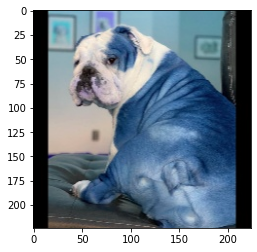

In [ ]:
plt.imshow(cv2.imread('/content/resized/bulldog_fat/bull_fat_001.jpg'))

In [ ]:
splitfolders.ratio('resized', output='dataset', seed=77, ratio=(.6,.4))   # 폴더 안에 데이터가 있는 경우 -> 6:2:2로 트레인 벨리데이션 테스트로 나눔
                                                                                  # validation 검증용

Copying files: 2001 files [00:00, 6128.94 files/s]


In [ ]:
folder_path = '/content/dataset/train'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [ ]:
label2index = {'bulldog_fat' : 0, 'bulldog_no' : 1 , 'chihuahua_fat' : 2 , 'chihuahua_no' : 3,
               'dachshund_fat' : 4, 'dachshund_no' : 5, 'goldenretriever_fat': 6, 'goldenretriever_no' : 7, 
               'pug_fat' : 8, 'pug_no' : 9, 'shiba_fat' : 10, 'shiba_no' : 11, 'welshcorgi_fat' : 12, 'welshcorgi_no':13
}

In [ ]:
x_train, y_train = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_train.append(image)
        y_train.append(label2index[label]) # label을 index로 변경

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = x_train.astype('int8')

In [ ]:
x_train.shape, y_train.shape 

((1198, 224, 224, 3), (1198,))

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,    # 회전시키는 범위, 40도까지
    width_shift_range=0.2,  # 옆으로 이동하는 범위, 20%까지
    height_shift_range=0.2, # 위아래로 이동하는 범위, 20%까지
    shear_range=0.2,     # 사다리꼴로 휘어짐
    zoom_range=0.2,
    horizontal_flip=True,   # 좌우로 뒤집기
    vertical_flip=True,     # 위아래로 뒤집기
)

In [ ]:
two = ['bulldog_fat', 'bulldog_no', 'goldenretriever_fat', 'goldenretriever_no']
three = ['dachshund_fat', 'dachshund_no']
four = ['chihuahua_fat', 'chihuahua_no', 'pug_fat', 'pug_no', 'welshcorgi_fat', 'welshcorgi_no']
six = ['shiba_fat', 'shiba_no']

In [ ]:
for label in  tqdm(os.listdir(folder_path)):
    label_path = folder_path + '/' + label + '/'
    for filename in tqdm(os.listdir(label_path)): 
        filepath = label_path + filename

        img = load_img(filepath)
        # img 출력
        # plt.imshow(img)
        # break
        x = img_to_array(img)
        # x.shape 출력
        # print(x.shape)
        # break
        x = x.reshape((1,) + x.shape)   # x.reshape((1,) -> 데이터 묶음의 갯수가 맨 앞에 들어감

        i = 0
        # flow : augmentation 함수
        for batch in datagen.flow(x, batch_size=1,  # datagen: image generator / for문 뒤에 들어가면, for문 안에서 실행 시키고 종속코드가 실행된다. 
                                save_to_dir=label_path, save_prefix=label, save_format='jpg'):
            i += 1
            if label in two:
                if i > 0:              # 0보다 크면 break  => flow를 1번 실행시키는 코드
                    break  
            
            elif label in three:
                if i > 1:              # 1보다 크면 break  => flow를 2번 실행시키는 코드                  
                    break 
                
            elif label in four:
                if i > 2:              # 2보다 크면 break  => flow를 3번 실행시키는 코드                   
                    break 

            elif label in six:
                if i > 4:             # 4보다 크면 break  => flow를 5번 실행시키는 코드                    
                    break

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
folder_path = '/content/dataset/train'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [ ]:
x_train, y_train = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_train.append(image)
        y_train.append(label2index[label]) # label을 index로 변경

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = x_train.astype('int8')

In [ ]:
x_train.shape, y_train.shape

((3553, 224, 224, 3), (3553,))

In [ ]:
# dataset의 val폴더의 이름을 test로 변경 후 진행

In [ ]:
folder_path = '/content/dataset/test'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [ ]:
x_test, y_test = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_test.append(image)
        y_test.append(label2index[label]) # label을 index로 변경

In [ ]:
x_test, y_test= np.array(x_test), np.array(y_test)

In [ ]:
x_test = x_test.astype('int8')

In [ ]:
x_test.shape, y_test.shape

((803, 224, 224, 3), (803,))

In [ ]:
# 기본 모델 = 완전연결계층 = Dense   쌓고 싶은 레이어를 쌓음. 5층 쌓음 -> 퍼셉트론으론 4층(입력층 제외) / 가장 기본적인 구조 = 가장 밀집한 구조 => Dense / 층이 깊
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),  # 320x320을 1차원으로 핌 / # 이미지 사이즈, 바꾸면 안됨. 데이터에 의해 결정된 값
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # dense 가장 기본적인 뉴럴넥을 쌓을 때 / glorot_uniform: 자비에 초기화
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # default는 relu
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    tf.keras.layers.Dense(14, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros') # 라벨의 갯수, 바꾸면 안됨. 데이터에 의해 결정된 값 => softmax이므로 각각의 확률값이 나오고 그 합은 1이 된다. 
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # 다중 분류를 할 때 오차를 계산하는 방법 / log-loss = binary cross entropy : 이진분류에 적합
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=20, verbose=1, batch_size=100, validation_data=(x_test, y_test))    

Epoch 1/20
36/36 [==============================] - 4s 104ms/step - loss: 756.8475 - accuracy: 0.0991 - val_loss: 391.3902 - val_accuracy: 0.1208
Epoch 2/20
36/36 [==============================] - 2s 67ms/step - loss: 191.1271 - accuracy: 0.2876 - val_loss: 117.1020 - val_accuracy: 0.1482
Epoch 3/20
36/36 [==============================] - 2s 67ms/step - loss: 28.6727 - accuracy: 0.2409 - val_loss: 5.7920 - val_accuracy: 0.0685
Epoch 4/20
36/36 [==============================] - 2s 67ms/step - loss: 5.3841 - accuracy: 0.1433 - val_loss: 3.1909 - val_accuracy: 0.0598
Epoch 5/20
36/36 [==============================] - 2s 67ms/step - loss: 3.2939 - accuracy: 0.1610 - val_loss: 3.0906 - val_accuracy: 0.1320
Epoch 6/20
36/36 [==============================] - 2s 66ms/step - loss: 2.7634 - accuracy: 0.1677 - val_loss: 2.9578 - val_accuracy: 0.1333
Epoch 7/20
36/36 [==============================] - 2s 67ms/step - loss: 2.5357 - accuracy: 0.1711 - val_loss: 3.0325 - val_accuracy: 0.1507
Epo

In [ ]:
folder_path = '/content/drive/MyDrive/Augmentation/final' # 각자 원하는 드라이브 경로에 맞게 수정합시다.

In [ ]:
with open(folder_path+'aug224_x_train.pickle', 'wb') as f:
    pickle.dump(x_train, f)

In [ ]:
with open(folder_path+'aug224_y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

In [ ]:
with open(folder_path+'aug224_x_test.pickle', 'wb') as f:
    pickle.dump(x_test, f)

In [ ]:
with open(folder_path+'aug224_y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
# Zero Centering

def zero_mean(image):
    # zero-centering
    return np.mean(image, axis=0)

In [ ]:
zero_mean_img = zero_mean(x_train)

In [ ]:
zero_mean_img.shape

(224, 224, 3)

In [ ]:
zero_mean_img = zero_mean_img.astype('int8') # 메모리 문제로 int8로 변환(근사값으로 사용)  int8, uint8, float32 

In [ ]:
x_train -= zero_mean_img
x_test -= zero_mean_img

In [ ]:
x_train.shape, x_test.shape

((3553, 224, 224, 3), (803, 224, 224, 3))

In [ ]:
# 기본 모델 = 완전연결계층 = Dense   쌓고 싶은 레이어를 쌓음. 5층 쌓음 -> 퍼셉트론으론 4층(입력층 제외) / 가장 기본적인 구조 = 가장 밀집한 구조 => Dense / 층이 깊
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),  # 320x320을 1차원으로 핌 / # 이미지 사이즈, 바꾸면 안됨. 데이터에 의해 결정된 값
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # dense 가장 기본적인 뉴럴넥을 쌓을 때 / glorot_uniform: 자비에 초기화
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # default는 relu
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    tf.keras.layers.Dense(14, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros') # 라벨의 갯수, 바꾸면 안됨. 데이터에 의해 결정된 값 => softmax이므로 각각의 확률값이 나오고 그 합은 1이 된다. 
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # 다중 분류를 할 때 오차를 계산하는 방법 / log-loss = binary cross entropy : 이진분류에 적합
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=20, verbose=1, batch_size=100, validation_data=(x_test, y_test))   

Epoch 1/20
36/36 [==============================] - 4s 105ms/step - loss: 589.1850 - accuracy: 0.0974 - val_loss: 87.1887 - val_accuracy: 0.0884
Epoch 2/20
36/36 [==============================] - 2s 68ms/step - loss: 17.6846 - accuracy: 0.1100 - val_loss: 2.8999 - val_accuracy: 0.1220
Epoch 3/20
36/36 [==============================] - 2s 67ms/step - loss: 2.9633 - accuracy: 0.0996 - val_loss: 2.7644 - val_accuracy: 0.1407
Epoch 4/20
36/36 [==============================] - 2s 67ms/step - loss: 2.7000 - accuracy: 0.1089 - val_loss: 2.6912 - val_accuracy: 0.1420
Epoch 5/20
36/36 [==============================] - 2s 67ms/step - loss: 2.6054 - accuracy: 0.1100 - val_loss: 2.6711 - val_accuracy: 0.1420
Epoch 6/20
36/36 [==============================] - 2s 67ms/step - loss: 2.5949 - accuracy: 0.1103 - val_loss: 2.6613 - val_accuracy: 0.1420
Epoch 7/20
36/36 [==============================] - 2s 67ms/step - loss: 2.5926 - accuracy: 0.1106 - val_loss: 2.6584 - val_accuracy: 0.1420
Epoch 8/

In [ ]:
with open(folder_path+'aug224_zero_x_train.pickle', 'wb') as f:
    pickle.dump(x_train, f)

In [ ]:
with open(folder_path+'aug224_zero_y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

In [ ]:
with open(folder_path+'aug224_zero_x_test.pickle', 'wb') as f:
    pickle.dump(x_test, f)

In [ ]:
with open(folder_path+'aug224_zero_y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)

#### Resize = 200 for EfficientNet, ResNet

In [ ]:
folder_path = '/content/drive/MyDrive/final'
label_names = os.listdir(folder_path)  # 해당경로의 하위목록의 폴더이름을 리스트로 뽑아냄 
label_names

['welshcorgi_fat',
 'goldenretriever_no',
 'shiba_no',
 'shiba_fat',
 'pug_fat',
 'dachshund_fat',
 'pug_no',
 'goldenretriever_fat',
 'welshcorgi_no',
 'dachshund_no',
 'chihuahua_no',
 'bulldog_fat',
 'chihuahua_fat',
 'bulldog_no']

In [ ]:
dataset = {}

# 이미지와 라벨 리스트에 담기  # label names가 돌면서
for label in os.listdir(folder_path):    
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []   # dataset에 label 선언
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [ ]:
!mkdir resized  

In [ ]:
!mkdir resized/bulldog_fat
!mkdir resized/bulldog_no
!mkdir resized/chihuahua_fat
!mkdir resized/chihuahua_no
!mkdir resized/dachshund_fat
!mkdir resized/dachshund_no
!mkdir resized/goldenretriever_fat
!mkdir resized/goldenretriever_no
!mkdir resized/pug_fat
!mkdir resized/pug_no
!mkdir resized/shiba_fat
!mkdir resized/shiba_no
!mkdir resized/welshcorgi_fat
!mkdir resized/welshcorgi_no

In [ ]:
for label, filenames in tqdm(dataset.items()):
    for filename in filenames:
        img = cv2.imread(filename)  # 해당이미지를 읽어들여서 저장하겠다. 

# 직사각형의 이미지를 읽어 들여서 가로와 세로 길이를 확인, 짧은 쪽을 긴 쪽에 맞춤 -> 정사각형으로 맞춤 -> 검정 패딩을 씌움
        # 이미지의 x, y가 224이 넘을 경우 작게해주기
        percent = 1
        if(img.shape[1] > img.shape[0]) :       # 이미지의 가로가 세보다 크면 가로를 640으로 맞추고 세로를 비율에 맞춰서
            percent = 200/img.shape[1]          # 열이 큰지 행이 큰지 비교 -> 큰쪽 사이즈에 맞춤 
        else :
            percent = 200/img.shape[0]

        img = cv2.resize(img, dsize=(0, 0), fx=percent, fy=percent, interpolation=cv2.INTER_LINEAR)   # fx와 fy의 비율은 동일하게. 
                # 이미지 범위 지정
        y,x,h,w = (0,0,img.shape[0], img.shape[1])   # height 세로, width 가로

        # 그림 주변에 검은색으로 칠하기
        w_x = (200-(w-x))/2  # w_x = (224 - 그림)을 뺀 나머지 영역 크기 [ 그림나머지/2 [그림] 그림나머지/2 ]    x=0, y=0
        h_y = (200-(h-y))/2

        if(w_x < 0):         # 크기가 -면 0으로 지정.
            w_x = 0
        elif(h_y < 0):
            h_y = 0

        M = np.float32([[1,0,w_x], [0,1,h_y]])  #(2*3 이차원 행렬)
        img_re = cv2.warpAffine(img, M, (200, 200)) #이동변환  
       
        # cv2.imwrite('{0}.jpg',image .format(file)) #파일저장
        cv2.imwrite('/content/resized/{0}/{1}'.format(label, filename.split("/")[-1]) , img_re)

  0%|          | 0/14 [00:00<?, ?it/s]

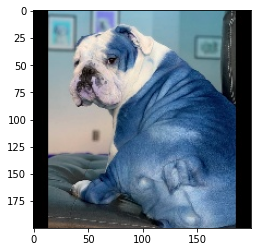

In [ ]:
plt.imshow(cv2.imread('/content/resized/bulldog_fat/bull_fat_001.jpg'))

In [ ]:
splitfolders.ratio('resized', output='dataset', seed=77, ratio=(.6,.4))   # 폴더 안에 데이터가 있는 경우 -> 6:2:2로 트레인 벨리데이션 테스트로 나눔
                                                                                  # validation 검증용

Copying files: 2001 files [00:00, 8209.06 files/s]


In [ ]:
folder_path = '/content/dataset/train'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [ ]:
label2index = {'bulldog_fat' : 0, 'bulldog_no' : 1 , 'chihuahua_fat' : 2 , 'chihuahua_no' : 3,
               'dachshund_fat' : 4, 'dachshund_no' : 5, 'goldenretriever_fat': 6, 'goldenretriever_no' : 7, 
               'pug_fat' : 8, 'pug_no' : 9, 'shiba_fat' : 10, 'shiba_no' : 11, 'welshcorgi_fat' : 12, 'welshcorgi_no':13
}

In [ ]:
x_train, y_train = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_train.append(image)
        y_train.append(label2index[label]) # label을 index로 변경

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = x_train.astype('int8')

In [ ]:
x_train.shape, y_train.shape  # 4,136개 img가 224X224 사이즈로 들어가 있음. 

((1198, 200, 200, 3), (1198,))

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,    # 회전시키는 범위, 40도까지
    width_shift_range=0.2,  # 옆으로 이동하는 범위, 20%까지
    height_shift_range=0.2, # 위아래로 이동하는 범위, 20%까지
    shear_range=0.2,     # 사다리꼴로 휘어짐
    zoom_range=0.2,
    horizontal_flip=True,   # 좌우로 뒤집기
    vertical_flip=True,     # 위아래로 뒤집기
)

In [ ]:
two = ['bulldog_fat', 'bulldog_no', 'goldenretriever_fat', 'goldenretriever_no']
three = ['dachshund_fat', 'dachshund_no']
four = ['chihuahua_fat', 'chihuahua_no', 'pug_fat', 'pug_no', 'welshcorgi_fat', 'welshcorgi_no']
six = ['shiba_fat', 'shiba_no']

In [ ]:
for label in  tqdm(os.listdir(folder_path)):
    label_path = folder_path + '/' + label + '/'
    for filename in tqdm(os.listdir(label_path)): 
        filepath = label_path + filename

        img = load_img(filepath)
        # img 출력
        # plt.imshow(img)
        # break
        x = img_to_array(img)
        # x.shape 출력
        # print(x.shape)
        # break
        x = x.reshape((1,) + x.shape)   # x.reshape((1,) -> 데이터 묶음의 갯수가 맨 앞에 들어감

        i = 0
        # flow : augmentation 함수
        for batch in datagen.flow(x, batch_size=1,  # datagen: image generator / for문 뒤에 들어가면, for문 안에서 실행 시키고 종속코드가 실행된다. 
                                save_to_dir=label_path, save_prefix=label, save_format='jpg'):
            i += 1
            if label in two:
                if i > 0:              # 0보다 크면 break  => flow를 1번 실행시키는 코드
                    break  
            
            elif label in three:
                if i > 1:              # 1보다 크면 break  => flow를 2번 실행시키는 코드                  
                    break 
                
            elif label in four:
                if i > 2:              # 2보다 크면 break  => flow를 3번 실행시키는 코드                   
                    break 

            elif label in six:
                if i > 4:             # 4보다 크면 break  => flow를 5번 실행시키는 코드                    
                    break

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
folder_path = '/content/dataset/train'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [ ]:
x_train, y_train = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_train.append(image)
        y_train.append(label2index[label]) # label을 index로 변경

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = x_train.astype('int8')

In [ ]:
x_train.shape, y_train.shape

((3557, 200, 200, 3), (3557,))

In [ ]:
folder_path = '/content/dataset/test'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [ ]:
x_test, y_test = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_test.append(image)
        y_test.append(label2index[label]) # label을 index로 변경

In [ ]:
x_test, y_test= np.array(x_test), np.array(y_test)

In [ ]:
x_test = x_test.astype('int8')

In [ ]:
x_test.shape, y_test.shape

((803, 200, 200, 3), (803,))

In [ ]:
# 기본 모델 = 완전연결계층 = Dense   쌓고 싶은 레이어를 쌓음. 5층 쌓음 -> 퍼셉트론으론 4층(입력층 제외) / 가장 기본적인 구조 = 가장 밀집한 구조 => Dense / 층이 깊
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 200, 3)),  # 320x320을 1차원으로 핌 / # 이미지 사이즈, 바꾸면 안됨. 데이터에 의해 결정된 값
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # dense 가장 기본적인 뉴럴넥을 쌓을 때 / glorot_uniform: 자비에 초기화
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # default는 relu
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    tf.keras.layers.Dense(14, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros') # 라벨의 갯수, 바꾸면 안됨. 데이터에 의해 결정된 값 => softmax이므로 각각의 확률값이 나오고 그 합은 1이 된다. 
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # 다중 분류를 할 때 오차를 계산하는 방법 / log-loss = binary cross entropy : 이진분류에 적합
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=20, verbose=1, batch_size=100, validation_data=(x_test, y_test))

Epoch 1/20
36/36 [==============================] - 4s 85ms/step - loss: 560.7673 - accuracy: 0.0964 - val_loss: 182.8178 - val_accuracy: 0.1096
Epoch 2/20
36/36 [==============================] - 2s 56ms/step - loss: 41.2339 - accuracy: 0.1605 - val_loss: 3.9100 - val_accuracy: 0.1220
Epoch 3/20
36/36 [==============================] - 2s 57ms/step - loss: 3.6486 - accuracy: 0.1085 - val_loss: 2.9121 - val_accuracy: 0.1258
Epoch 4/20
36/36 [==============================] - 2s 56ms/step - loss: 2.8949 - accuracy: 0.1245 - val_loss: 2.9169 - val_accuracy: 0.1432
Epoch 5/20
36/36 [==============================] - 2s 57ms/step - loss: 2.7823 - accuracy: 0.1285 - val_loss: 2.8881 - val_accuracy: 0.1432
Epoch 6/20
36/36 [==============================] - 2s 56ms/step - loss: 2.6483 - accuracy: 0.1279 - val_loss: 2.7728 - val_accuracy: 0.1432
Epoch 7/20
36/36 [==============================] - 2s 58ms/step - loss: 2.5561 - accuracy: 0.1296 - val_loss: 2.7600 - val_accuracy: 0.1432
Epoch 8/

In [ ]:
folder_path = '/content/drive/MyDrive/Aug_200' # 각자 원하는 드라이브 경로에 맞게 수정합시다.

In [ ]:
with open(folder_path+'Aug_200_x_train.pickle', 'wb') as f:
    pickle.dump(x_train, f)

In [ ]:
with open(folder_path+'Aug_200_y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

In [ ]:
with open(folder_path+'Aug_200_x_test.pickle', 'wb') as f:
    pickle.dump(x_test, f)

In [ ]:
with open(folder_path+'Aug_200_y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
# Zero Centering

def zero_mean(image):
    # zero-centering
    return np.mean(image, axis=0)

In [ ]:
zero_mean_img = zero_mean(x_train)

In [ ]:
zero_mean_img.shape

(200, 200, 3)

In [ ]:
zero_mean_img = zero_mean_img.astype('int8') # 메모리 문제로 int8로 변환(근사값으로 사용)  int8, uint8, float32 

In [ ]:
x_train -= zero_mean_img
x_test -= zero_mean_img

In [ ]:
x_train.shape, x_test.shape

((3557, 200, 200, 3), (803, 200, 200, 3))

In [ ]:
# 기본 모델 = 완전연결계층 = Dense   쌓고 싶은 레이어를 쌓음. 5층 쌓음 -> 퍼셉트론으론 4층(입력층 제외) / 가장 기본적인 구조 = 가장 밀집한 구조 => Dense / 층이 깊
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 200, 3)),  # 320x320을 1차원으로 핌 / # 이미지 사이즈, 바꾸면 안됨. 데이터에 의해 결정된 값
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # dense 가장 기본적인 뉴럴넥을 쌓을 때 / glorot_uniform: 자비에 초기화
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),  # default는 relu
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    tf.keras.layers.Dense(14, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros') # 라벨의 갯수, 바꾸면 안됨. 데이터에 의해 결정된 값 => softmax이므로 각각의 확률값이 나오고 그 합은 1이 된다. 
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # 다중 분류를 할 때 오차를 계산하는 방법 / log-loss = binary cross entropy : 이진분류에 적합
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=20, verbose=1, batch_size=100, validation_data=(x_test, y_test))

Epoch 1/20
36/36 [==============================] - 4s 85ms/step - loss: 530.7531 - accuracy: 0.1029 - val_loss: 177.3964 - val_accuracy: 0.1146
Epoch 2/20
36/36 [==============================] - 2s 54ms/step - loss: 33.5882 - accuracy: 0.1453 - val_loss: 3.0933 - val_accuracy: 0.1220
Epoch 3/20
36/36 [==============================] - 2s 56ms/step - loss: 3.0343 - accuracy: 0.1077 - val_loss: 2.6392 - val_accuracy: 0.1407
Epoch 4/20
36/36 [==============================] - 2s 54ms/step - loss: 2.6673 - accuracy: 0.1133 - val_loss: 2.6715 - val_accuracy: 0.1407
Epoch 5/20
36/36 [==============================] - 2s 55ms/step - loss: 2.7032 - accuracy: 0.1150 - val_loss: 2.6950 - val_accuracy: 0.1407
Epoch 6/20
36/36 [==============================] - 2s 54ms/step - loss: 2.6328 - accuracy: 0.1147 - val_loss: 2.6602 - val_accuracy: 0.1407
Epoch 7/20
36/36 [==============================] - 2s 55ms/step - loss: 2.5987 - accuracy: 0.1158 - val_loss: 2.6526 - val_accuracy: 0.1407
Epoch 8/

In [ ]:
folder_path = '/content/drive/MyDrive/Aug_200' # 각자 원하는 드라이브 경로에 맞게 수정합시다.

In [ ]:
with open(folder_path+'Aug_200_zero_x_train.pickle', 'wb') as f:
    pickle.dump(x_train, f)

In [ ]:
with open(folder_path+'Aug_200_zero_y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

In [ ]:
with open(folder_path+'Aug_200_zero_x_test.pickle', 'wb') as f:
    pickle.dump(x_test, f)

In [ ]:
with open(folder_path+'Aug_200_zero_y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)